In [1]:
from brian2 import *
from brian2tools import *
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


from plotting_helper import * 

figures_path = 'figures/'
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']  

/home/patricia/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:

tau_Ca = 1 * ms
tau_w = 1 * ms
dv = -30*mV #reset so we have a spike adaption for bursts, -30 means no adaption

E_exc = 0 * mV 
vrest = -79 * mV
tau_syn_e = 10 * ms
g_EE = 0.1

#we add the parameter as parameters in the equation as well, so we can easily change them in the wrapper below
vdp_eq = '''
    dglutamate/dt = - glutamate/tau_glutamate : 1 (clock-driven)
    sig_LTP = 1/(1+exp(k_LTP*(-(v - theta_NMDA)+0*mV))) : 1 (constant over dt)
    dv_NMDA_rise/dt = (-v_NMDA_rise + clip(clip(sig_LTP - v_NMDA,0,100) - v_NMDA_rise,0,100))/tau_NMDA_rise : 1 (clock-driven)             
    dv_NMDA/dt = (NMDA_amp * v_NMDA_rise - v_NMDA)/tau_NMDA_fall : 1 (clock-driven)
    sig_LTD = 1/(1+exp(k_LTD*(-(v - theta_VDCC)+0*mV))) : 1 (constant over dt)
    dVDCC_rise/dt = (-VDCC_rise + clip(clip(sig_LTD - VDCC,0,100) -VDCC_rise, 0, 100))/tau_VDCC_rise : 1 (clock-driven) 
    dVDCC/dt = (VDCC_amp * VDCC_rise - VDCC) * 1/tau_VDCC_fall : 1 (clock-driven)
    Ca = VDCC**(exp(-c_ca)*20) + v_NMDA**(exp(-c_ca)*20) * int(glutamate>0) : 1 (constant over dt)
    dw/dt = clip(eta * Ca  * (v_NMDA * LTP_amp - VDCC * LTD_amp) * glutamate/tau_w*dt,(wmin-w),(wmax-w))/dt : 1 (clock-driven)
    tau_glutamate :second
    theta_NMDA : volt
    tau_NMDA_rise : second
    tau_NMDA_fall : second
    NMDA_amp : 1
    theta_VDCC : volt
    tau_VDCC_rise : second
    tau_VDCC_fall : second
    VDCC_amp : 1
    k_LTP : 1/volt
    k_LTD : 1/volt
    LTP_amp : 1
    LTD_amp : 1
    Apre : 1  #this is technically decided by tau_glutamate but just adding it here for completeness sake
    eta : 1
    wmin : 1
    wmax : 1
    c_ca : 1
'''

cl_eq = '''
    dvp/dt = (-vp + v)/tau_p : volt (clock-driven)
    dvm/dt = (-vm + v)/tau_m : volt (clock-driven)
    ds/dt = -s/tau_s : 1 (clock-driven)
    dw/dt = clip(eta * A_p  * (v - theta_p)/mV * int((v - theta_p)/mV > 0 ) * (vp - theta_m)/mV*int((vp - theta_m)/mV > 0 ) * s / tau_w *dt, (wmin - w), (wmax-w))/dt : 1 (clock-driven)
    tau_p : second
    tau_m : second
    tau_s : second
    A_p : 1
    A_d : 1
    theta_p : volt
    theta_m : volt
    g : 1
    eta : 1
    wmin : 1
    wmax : 1
'''

mb_eq = '''
    dvp/dt = (-vp + v)/tau_p : volt (clock-driven)
    dvm/dt = (-vm + v)/tau_m : volt (clock-driven)
    ds/dt = -s/tau_s : 1 (clock-driven)
    dw/dt = clip(eta * (A_p  * (vp - theta_p)/mV*int((vp - theta_p)/mV > 0 ) - A_d *(vm - theta_m)/mV * int((vm - theta_m)/mV > 0)) * s /tau_w * dt, (wmin - w), (wmax-w))/dt : 1 (clock-driven)
    tau_p : second
    tau_m : second
    tau_s : second
    A_p : 1
    A_d : 1
    theta_p : volt
    theta_m : volt
    g : 1
    eta : 1
    tau_w : second
    wmin : 1
    wmax : 1

'''

on_pre_vdp = '''
    glutamate +=Apre
    '''
on_pre_vdp_trans = '''
    glutamate +=Apre
    g_syn_e += g_EE * w
    '''

on_pre_cl = '''
    s += g
    w =clip(w - eta * 0.1 * A_d *(vm - theta_m)/mV * int((vm - theta_m)/mV > 0), wmin, wmax)
    '''

on_pre_cl_trans = '''
    s += g
    w =clip(w - eta * 0.1 * A_d *(vm - theta_m)/mV * int((vm - theta_m)/mV > 0), wmin, wmax)
    g_syn_e += g_EE * w
    '''

on_pre_mb = '''
    s += g'''

on_pre_mb_trans = '''
    s += g
    g_syn_e += g_EE * w
    '''



neuron_eqs_single = '''
    dv/dt = (vrest-v)/tau + I_stim(t)/tau: volt (unless refractory)
    tau : second
    vthresh : volt
'''

neuron_eqs_multi = '''
    dv/dt = (vrest-v)/tau + I_stim(t,i)/tau: volt (unless refractory)
    tau : second
    vthresh : volt
'''

neuron_eqs_freq = '''
    dv/dt = (vrest-v)/tau -g_syn_e * (v-E_exc)/tau: volt (unless refractory)
    dg_syn_e/dt = -g_syn_e/tau_syn_e : 1 
    tau : second
    vthresh : volt
'''

reset_set = '''
    v = -79*mV
'''

reset_addapt = '''
    v += dv
'''

def unpack_params(Syn, params): 
    
    Syn.Apre = params[0]
    Syn.tau_glutamate = params[1] *ms
    
    Syn.k_LTD = params[2] /mV 
    LTD_rise = params[3] 
    LTD_fall = params[4] 
    
    Syn.tau_VDCC_rise = LTD_rise * ms
    Syn.tau_VDCC_fall = LTD_fall * ms
    Syn.theta_VDCC  = params[5] * mV 
    Syn.LTD_amp = params[6]
    
    Syn.k_LTP = params[7] / mV
    LTP_rise = params[8] 
    LTP_fall = params[9] 
    Syn.tau_NMDA_rise = LTP_rise * ms
    Syn.tau_NMDA_fall =  LTP_fall * ms
    Syn.theta_NMDA = params[10] * mV 
    Syn.LTP_amp =  params[11]
    Syn.eta = params[12]
    Syn.wmin = params[13]
    Syn.wmax = params[14]
    Syn.c_ca = params[15]
    
    #predetermined by time constants
    Syn.NMDA_amp = (LTP_rise/LTP_fall)**(LTP_fall/(LTP_rise - LTP_fall))
    Syn.VDCC_amp = (LTD_rise/LTD_fall)**(LTD_fall/(LTD_rise - LTD_fall))
    
    
    return Syn

def unpack_cl_params(Syn, params):
    
    Syn.g = params[0] 
    Syn.tau_s = params[1] *ms
    
    Syn.tau_m = params[2] *ms
    Syn.tau_p = params[3] * ms
    Syn.A_d = params[4]
    Syn.A_p = params[5]
    Syn.theta_m = params[6] *mV
    Syn.theta_p = params[7] * mV
    Syn.eta = params[8]
    Syn.wmin = params[9]
    Syn.wmax = params[10]
    #need to initialise the filters to the correct starting mean
    Syn.vm = params[11] * mV
    Syn.vp = params[11] * mV
    
    return Syn


def unpack_mb_params(Syn, params): 
    Syn.g = params[0] 
    Syn.tau_s = params[1] *ms
    
    Syn.tau_m = params[2] *ms
    Syn.tau_p = params[3] * ms
    Syn.A_d = params[4]
    Syn.A_p = params[5]
    Syn.theta_m = params[6] *mV
    Syn.theta_p = params[7] * mV
    Syn.eta = params[8]
    Syn.wmin = params[9]
    Syn.wmax = params[10]
    Syn.tau_w = 1*ms
    #need to initialise the filters to the correct starting mean
    Syn.vm = params[11] * mV
    Syn.vp = params[11] * mV
    
    return Syn


def FreqDep(syn_eq, pre_exp, param_fun, params, test_freqs,w0, mon_ca = True):  
    #this is the sjoestroem protocoll
    
    start_scope()
    
    #set up the network
    GE = NeuronGroup(1, neuron_eqs_single, threshold='v > -49 * mV', 
                refractory=2*ms, method='euler', reset=reset_addapt) 
    GE.tau = 10*ms
    #GE.n_sigma = 0.0*mV
    GE.vthresh = -49*mV


    pre_spikes = np.arange(200,1500,300)
    IG_E = SpikeGeneratorGroup(1, np.zeros(pre_spikes.shape[0]), pre_spikes*ms)
    
    S_IG_E = Synapses(IG_E, GE, syn_eq,
                on_pre=pre_exp,
                method='euler')
    S_IG_E.connect(p=1)
    #we have no synaptic transfer here which might be a problem
    
    S_IG_E = param_fun(S_IG_E, params)

    
    #setup monitor
    M_IG_E_w = StateMonitor(S_IG_E, ['w'], record=range(1), dt=1 * ms)
    if mon_ca: 
        ca = StateMonitor(S_IG_E, ['Ca'], record = range(1), dt = 1*ms)
    
        net = Network(GE, IG_E, S_IG_E, M_IG_E_w, ca)
    else: 
        net = Network(GE, IG_E, S_IG_E, M_IG_E_w)
    net.store()
    
    final_w = []
    final_ca = []
    
    #switched here so it is easier to compare
    stdp_delays = np.array([10,-10])
    

    I_stim_duration = 1
    I_stim_amp = 500*mV
    
    num_spikes = 5 #how many pairings
    repeat_pairs =np.array([50,15])
    pre_offset = 50
    
    
    #the frequency experiment
    for f in range(test_freqs.shape[0]):
        final_w_t = []
        final_ca_t = []
        for i,stdp_dt in enumerate(stdp_delays):
        
            net.restore()
            dt_f = 1000/test_freqs[f]
            sim_time = int(pre_offset + dt_f * num_spikes +1000) 
            pre_spikes = np.arange(pre_offset,int(dt_f *num_spikes)+pre_offset,int(dt_f))
            if test_freqs[f] <= 5: 
                sim_time = int(pre_offset + 1000)
                pre_spikes = np.array([pre_offset])  #we ensure here that there are always the correct amount of spikes
            IG_E.set_spikes(np.zeros(pre_spikes.shape[0]), pre_spikes*ms)

            post_stims = np.zeros(sim_time)*volt
            for tp in pre_spikes:
                post_stims[tp+stdp_dt:tp+I_stim_duration+stdp_dt] = I_stim_amp

            I_stim = TimedArray(post_stims, dt=1*ms)

            GE.v = vrest
            S_IG_E.w = w0
            net.run(sim_time*ms)
            if mon_ca: 
                final_ca_t.append(np.amax(ca.Ca[0,:]))
            if test_freqs[f]<=5: 
                final_w_t.append((M_IG_E_w.w[0][-1]- w0)*repeat_pairs[0])
            else: 
                final_w_t.append((M_IG_E_w.w[0][-1]- w0)*repeat_pairs[1])
                
        final_w.append(final_w_t)
        if mon_ca:
            final_ca.append(final_ca_t)
    perc_w = np.asarray(final_w)/w0 * 100 + 100
    
    
    return perc_w, np.asarray(final_ca)


def STDP(syn_eq, pre_exp, param_fun, params, stdp_delays,w0, mon_ca = True): 
    start_scope()
    N = int(stdp_delays.shape[0])

    GE = NeuronGroup(N, neuron_eqs_multi, threshold='v > -49 * mV', 
                    refractory=3*ms, method='euler', reset=reset_set)
    GE.tau = 10*ms
    
    #maybe change this to have more pre spikes again
    pre_time = 200
    pre_spikes = np.zeros(N, dtype = 'int')
    for post_ind, post in enumerate(stdp_delays): 
        pre_spikes[post_ind] = pre_time
        
    IG_E = SpikeGeneratorGroup(N, np.arange(N), pre_spikes*ms)

    # Synapses
    ##########################################
    S_IG_E = Synapses(IG_E, GE, syn_eq,
                on_pre=pre_exp,
                method='euler')
    S_IG_E.connect(condition='i == j')
    
    S_IG_E = param_fun(S_IG_E, params)
    
     
    # Monitors
    ##########################################

    M_IG_E_w = StateMonitor(S_IG_E, ['w'], record=True, dt=1 * ms)
    if mon_ca: 
        CA = StateMonitor(S_IG_E, ['Ca'], record = True, dt = 1 * ms)
    
    
        net = Network(GE, IG_E, S_IG_E, M_IG_E_w, CA)
    else: 
        net = Network(GE, IG_E, S_IG_E, M_IG_E_w)
    net.store()

    ##########################################

    I_stim_duration = 1 
    I_stim_amp = 500*mV


    post_stims = np.zeros((1000, N))*volt
    for ind, stdp_dt in enumerate(stdp_delays):
            post_stims[pre_time+int(stdp_dt):pre_time+I_stim_duration+int(stdp_dt), ind] = I_stim_amp
    I_stim = TimedArray(post_stims, dt=1*ms)


    GE.v = vrest
    S_IG_E.w = w0

    net.run(1000*ms)

        
    perc_w = (M_IG_E_w.w[:,-1] - w0)/w0 * 100 + 100
    
    if mon_ca: 
        return perc_w, np.amax(CA.Ca, axis = 1)
    else: 
        return perc_w, perc_w*0

def vdep(syn_eq, pre_exp, param_fun, params, v_values,w0, mon_ca = True): 
    start_scope()

    GE = NeuronGroup(v_values.shape[0], '''v : volt''',
                     refractory=0*ms,   method='euler')
    GE.v = vrest
    
    pre_spikes = np.zeros([v_values.shape[0]])
    pre_spikes[:] = 10
    IG_E = SpikeGeneratorGroup(v_values.shape[0], np.arange(v_values.shape[0]), pre_spikes*ms)

    # Synapses
    ##########################################

    S_IG_E = Synapses(IG_E, GE, syn_eq,
                on_pre=pre_exp,
                method='euler')
    S_IG_E.connect(condition='i == j')
    S_IG_E = param_fun(S_IG_E, params)
    

    # Monitors
    ##########################################
    M_IG_E_w = StateMonitor(S_IG_E, ['w'], record=True, dt=1 * ms)
    if mon_ca: 
        CA = StateMonitor(S_IG_E, ['Ca'], record = True, dt = 1 * ms)
    
    
        net = Network(GE, IG_E, S_IG_E, M_IG_E_w, CA)
    else: 
        net = Network(GE, IG_E, S_IG_E, M_IG_E_w)

    net.store()

    ##########################################

        
    GE.v = v_values * mV
    S_IG_E.w = w0

    net.run(1000*ms)
        
    perc_w = (M_IG_E_w.w[:,-1] - w0)/w0 * 100 + 100
    
    if mon_ca: 
        return perc_w, CA.Ca[:,-1]
    else: 
        return perc_w, perc_w*0

def LFSTBS(syn_eq, pre_exp,param_fun, params, w0, mon_ca = True): 
    start_scope()
    #parameters of the protocol
    freqs = np.array([1,10,25,50,75,100])
    #here we implement the experiment described in dudek et al 2000
    #this is a regular stimulation at 1Hz repeated 900 times 
    #and TBS at 100Hz with 5Hz repetition
    
    num_spikes = np.array([1,4,4,4,4,4])
    rep_bursts = np.array([1,10,10,10,10,10])
    repeat_factor = np.array([900,4,4,4,4,4]) #how many isolated events
    #repeat_factor = np.array([900,22,22,22,22,22])
    d_bursts = 200
    
    N = int(freqs.shape[0])

    GE = NeuronGroup(N, neuron_eqs_freq, threshold='v > -49 * mV', 
                    refractory=3*ms, method='euler', reset=reset_addapt)
    GE.tau = 10*ms
    pre_spikes = []
    inds = []

    for pre_ind, f in enumerate(freqs): 
        dt = 1000/f
        for b_count in range(rep_bursts[pre_ind]): 
            for s_count in range(num_spikes[pre_ind]): 
                pre_spikes.append(dt * s_count + (d_bursts + dt* (num_spikes[pre_ind]-1))* b_count )
                inds.append(pre_ind)
        
    
    inds = np.array(inds)
    pre_spikes = np.array(pre_spikes)
    sim_time = (dt* num_spikes[1]+d_bursts)*rep_bursts[1] + 2000 #+2s to allow for effects to tamper out

    IG_E = SpikeGeneratorGroup(N, inds, pre_spikes*ms)
    spikes = SpikeMonitor(GE)
    vs = StateMonitor(GE, ['v'], record = True, dt = 1*ms)

    # Synapses
    ##########################################
    S_IG_E = Synapses(IG_E, GE, syn_eq,
                on_pre=pre_exp,
                method='euler')
    S_IG_E.connect(condition='i == j')
    
    S_IG_E = param_fun(S_IG_E, params)
    
     
    # Monitors
    ##########################################

    M_IG_E_w = StateMonitor(S_IG_E, ['w'], record=True, dt=1 * ms)
    if mon_ca : 
        CA = StateMonitor(S_IG_E, ['Ca'], record = True, dt = 1 * ms)
    
    
        net = Network(GE, IG_E, S_IG_E, M_IG_E_w, CA)
    else: 
        net = Network(GE, IG_E, S_IG_E, M_IG_E_w)
    net.store()

    ##########################################

    GE.v = vrest
    S_IG_E.w = w0

    net.run(sim_time*ms)

        
    perc_w = (M_IG_E_w.w[:,-1] - w0)*repeat_factor/w0 * 100 + 100

    if mon_ca: 
        return perc_w, freqs, np.amax(CA.Ca, axis = 1)
    else: 
        return perc_w, freqs, perc_w * 0

In [63]:
###run the vdep protocol
eta = 10
v_params = [0.1, 10, 0.4, 20,21, -38.75, 0.5, 0.2, 20,35, -20.75, 1.0, eta , 0,3, 2.5]

v_cl_params = [1/15, 15, 10,7, 4.e-2, 4.e-4,-60, -25,10, 0, 3,-79]
v_mb_params = [1/15, 15, 10,7, 2.e-3, 4.e-2,-60, -25,10, 0, 3,-79]


data = pd.read_csv("data_from_exp_publication/ngezahayo_vdep_2000.csv")
vdep_dat = pd.DataFrame(data, columns = ['v', ' %w'])
vdat = vdep_dat.to_numpy()

N = 100
v_values = np.linspace(vdat[0,0], vdat[-1,0],N)

vdep_simdata, calcium = vdep(vdp_eq, on_pre_vdp, unpack_params, v_params, v_values,1)

vdep_simdata_cl, _ = vdep(cl_eq, on_pre_cl, unpack_cl_params, v_cl_params, v_values,1, mon_ca = False)
vdep_simdata_mb, _ = vdep(mb_eq, on_pre_mb, unpack_mb_params, v_mb_params, v_values,1, mon_ca = False)

In [4]:
###run the STDP kernel
eta = 100
stdp_params =   [0.1, 10, 0.4, 1,20, -63.75, 0.08, 0.2, 1,5, -45.75, 1.0, eta , 0,2, 4.0]
stdp_cl_params = [1/15, 15, 10,7, 1.e-2, 8.e-4,-69, -58,1, 0, 2,-79]
stdp_mb_params = [1/15, 15, 10,7, 1.e-2, 8.e-4,-69, -58,1, 0, 2,-79]
#[0.1, 10, 0.4, 3,50, -43.75,0.18, 0.4, 3,10, -40.75, 1, eta , 0,2, 2.0] 
data = pd.read_csv("data_from_exp_publication/froemke_dan_2002_stdp.csv")
stdp_data = pd.DataFrame(data, columns = ['stdp_dt', ' %w'])
stdp_dat = stdp_data.to_numpy()

stdp_dt = np.arange(-100,100, 2)

stdp_simdata, calcium_STDP = STDP(vdp_eq, on_pre_vdp, unpack_params,stdp_params, stdp_dt,1)
stdp_simdata_cl, _ = STDP(cl_eq, on_pre_cl, unpack_cl_params, stdp_cl_params, stdp_dt,1, mon_ca = False)
stdp_simdata_mb, _ = STDP(mb_eq, on_pre_mb, unpack_mb_params, stdp_mb_params, stdp_dt,1, mon_ca = False)

building '_cython_magic_2b303423cb65ca6111fe336639df3931' extension
INFO: C compiler: x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC

INFO: compile options: '-I/usr/include -I/home/patricia/.local/lib/python3.10/site-packages/numpy/core/include -I/home/patricia/.local/lib/python3.10/site-packages/brian2/synapses -I/usr/include/python3.10 -c'
extra options: '-w -O3 -ffast-math -fno-finite-math-only -march=native -std=c++11'
INFO: x86_64-linux-gnu-gcc: /home/patricia/.cython/brian_extensions/_cython_magic_2b303423cb65ca6111fe336639df3931.cpp
INFO: x86_64-linux-gnu-g++ -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -g -fwrapv -O2 /home/patricia/.cython/brian_extensions/home/patricia/.cython/brian_extensions/_cython_magic_2b303423cb65ca6111fe336639df3931.o -L/usr/lib -L/usr/lib/x86_64-linux-gnu -Wl,--enable-new-dtags,-R/usr/lib -o /home/patricia/.cython

WARNING    'eta' is an internal variable of group 'synapses', but also exists in the run namespace with the value 100. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


building '_cython_magic_ae7d41fc725ed875af34a726f27297de' extension
INFO: C compiler: x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC

INFO: compile options: '-I/usr/include -I/home/patricia/.local/lib/python3.10/site-packages/numpy/core/include -I/home/patricia/.local/lib/python3.10/site-packages/brian2/synapses -I/usr/include/python3.10 -c'
extra options: '-w -O3 -ffast-math -fno-finite-math-only -march=native -std=c++11'
INFO: x86_64-linux-gnu-gcc: /home/patricia/.cython/brian_extensions/_cython_magic_ae7d41fc725ed875af34a726f27297de.cpp
INFO: x86_64-linux-gnu-g++ -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -g -fwrapv -O2 /home/patricia/.cython/brian_extensions/home/patricia/.cython/brian_extensions/_cython_magic_ae7d41fc725ed875af34a726f27297de.o -L/usr/lib -L/usr/lib/x86_64-linux-gnu -Wl,--enable-new-dtags,-R/usr/lib -o /home/patricia/.cython

INFO: compile options: '-I/usr/include -I/home/patricia/.local/lib/python3.10/site-packages/numpy/core/include -I/home/patricia/.local/lib/python3.10/site-packages/brian2/synapses -I/usr/include/python3.10 -c'
extra options: '-w -O3 -ffast-math -fno-finite-math-only -march=native -std=c++11'
INFO: x86_64-linux-gnu-gcc: /home/patricia/.cython/brian_extensions/_cython_magic_600cb3e77b3934e943259950bb79bb56.cpp
INFO: x86_64-linux-gnu-g++ -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -g -fwrapv -O2 /home/patricia/.cython/brian_extensions/home/patricia/.cython/brian_extensions/_cython_magic_600cb3e77b3934e943259950bb79bb56.o -L/usr/lib -L/usr/lib/x86_64-linux-gnu -Wl,--enable-new-dtags,-R/usr/lib -o /home/patricia/.cython/brian_extensions/_cython_magic_600cb3e77b3934e943259950bb79bb56.cpython-310-x86_64-linux-gnu.so
building '_cython_magic_423b44ebd5185bc1f9c6be08e07650c2' extension
INFO: C compiler: x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwr

In [86]:
###run the LFSTBS protocol
eta = .1
w0 = 7
LFSTBS_params =  [0.1, 10, 0.4, 5,20, -63.75, 0.11, 0.2, 1,5, -45.75, 1.0, eta , 0,200, 2.5]
LFSTBS_cl_params = [1/15, 15, 10,7, 4.e-4, 8.e-6,-69, -65,10, 0, 200,-79]
LFSTBS_mb_params =  [1/15, 15, 10,7, 1.e-4, 8.e-4,-69, -65,1, 0, 200,-79]

lfstbs_simdata, freqs, calcium_freqs = LFSTBS(vdp_eq, on_pre_vdp_trans,unpack_params, LFSTBS_params,w0)
lfstbs_simdata_cl, freqs, _ = LFSTBS(cl_eq, on_pre_cl_trans, unpack_cl_params, LFSTBS_cl_params,w0, mon_ca = False)
lfstbs_simdata_mb, freqs, _ = LFSTBS(mb_eq, on_pre_mb_trans, unpack_mb_params, LFSTBS_mb_params,w0, mon_ca = False)


In [6]:
###run the FreqDep experiment
eta = 10
freqdep_params = [0.1, 10, 0.4, 3,20, -63.75, 0.1, 0.2, 1,5, -45.75, 1.0, eta , 0,2, 2.5]
freqdep_cl_params = [1/15, 15, 10,7, 4.e-2, 4.e-4,-69, -58,1, 0, 2,-79]
freqdep_mb_params = [1/15, 15, 10,7, 1.e-2, 8.e-4,-69, -58,1, 0, 2,-79]
#[0.1, 10, 0.4, 1,20, -43.75, 0.09, 0.4, 1,5, -40.75, 1.0, eta , 0,2, 2.5]
#that parameter set works equally well
test_freqs = np.array([0.3,10,20,40, 50])

fredep_simdata ,calcium_freqdep= FreqDep(vdp_eq, on_pre_vdp, unpack_params,freqdep_params, test_freqs,1)
fredep_simdata_cl ,_= FreqDep(cl_eq, on_pre_cl, unpack_cl_params, freqdep_cl_params, test_freqs,1, mon_ca = False)
fredep_simdata_mb ,_= FreqDep(mb_eq, on_pre_mb, unpack_mb_params, freqdep_mb_params, test_freqs,1, mon_ca = False)

building '_cython_magic_3d37908537499e275e059a912dc9104b' extension
INFO: C compiler: x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC

INFO: compile options: '-I/usr/include -I/home/patricia/.local/lib/python3.10/site-packages/numpy/core/include -I/home/patricia/.local/lib/python3.10/site-packages/brian2/synapses -I/usr/include/python3.10 -c'
extra options: '-w -O3 -ffast-math -fno-finite-math-only -march=native -std=c++11'
INFO: x86_64-linux-gnu-gcc: /home/patricia/.cython/brian_extensions/_cython_magic_3d37908537499e275e059a912dc9104b.cpp
INFO: x86_64-linux-gnu-g++ -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -g -fwrapv -O2 /home/patricia/.cython/brian_extensions/home/patricia/.cython/brian_extensions/_cython_magic_3d37908537499e275e059a912dc9104b.o -L/usr/lib -L/usr/lib/x86_64-linux-gnu -Wl,--enable-new-dtags,-R/usr/lib -o /home/patricia/.cython

INFO: x86_64-linux-gnu-gcc: /home/patricia/.cython/brian_extensions/_cython_magic_95ba245e829ca9319bc8fc03d5ee9bee.cpp
INFO: x86_64-linux-gnu-g++ -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -g -fwrapv -O2 /home/patricia/.cython/brian_extensions/home/patricia/.cython/brian_extensions/_cython_magic_95ba245e829ca9319bc8fc03d5ee9bee.o -L/usr/lib -L/usr/lib/x86_64-linux-gnu -Wl,--enable-new-dtags,-R/usr/lib -o /home/patricia/.cython/brian_extensions/_cython_magic_95ba245e829ca9319bc8fc03d5ee9bee.cpython-310-x86_64-linux-gnu.so
building '_cython_magic_a6681f5c0bb7c5a32d0f47bf07f544ef' extension
INFO: C compiler: x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC

INFO: compile options: '-I/usr/include -I/home/patricia/.local/lib/python3.10/site-packages/numpy/core/include -I/home/patricia/.local/lib/python3.10/site-packages/brian2/synapses -I/usr/include/p

In [7]:
###load all data sets: 
data = pd.read_csv("data_from_exp_publication/sjostrom_rate2001.csv")
rate_data = pd.DataFrame(data, columns = ['F', ' +10ms', ' -10ms'])
freqdep_sjostrom = rate_data.to_numpy()
#load Inglebert_data
data = pd.read_csv("data_from_exp_publication/Inglebert_2020_freqdep_stdp.csv")
rate_data = pd.DataFrame(data, columns = ['F', '1.3mMol(+10ms)', '1.3mMol(-25ms)'])
rate_data = rate_data.to_numpy()
freqdep_inglebert = np.zeros([2,2])
freqdep_inglebert[0,0] = rate_data[0,1]
freqdep_inglebert[1,0] = rate_data[3,1]
freqdep_inglebert[0,1] = rate_data[0,2]
freqdep_inglebert[1,1] = rate_data[3,2]



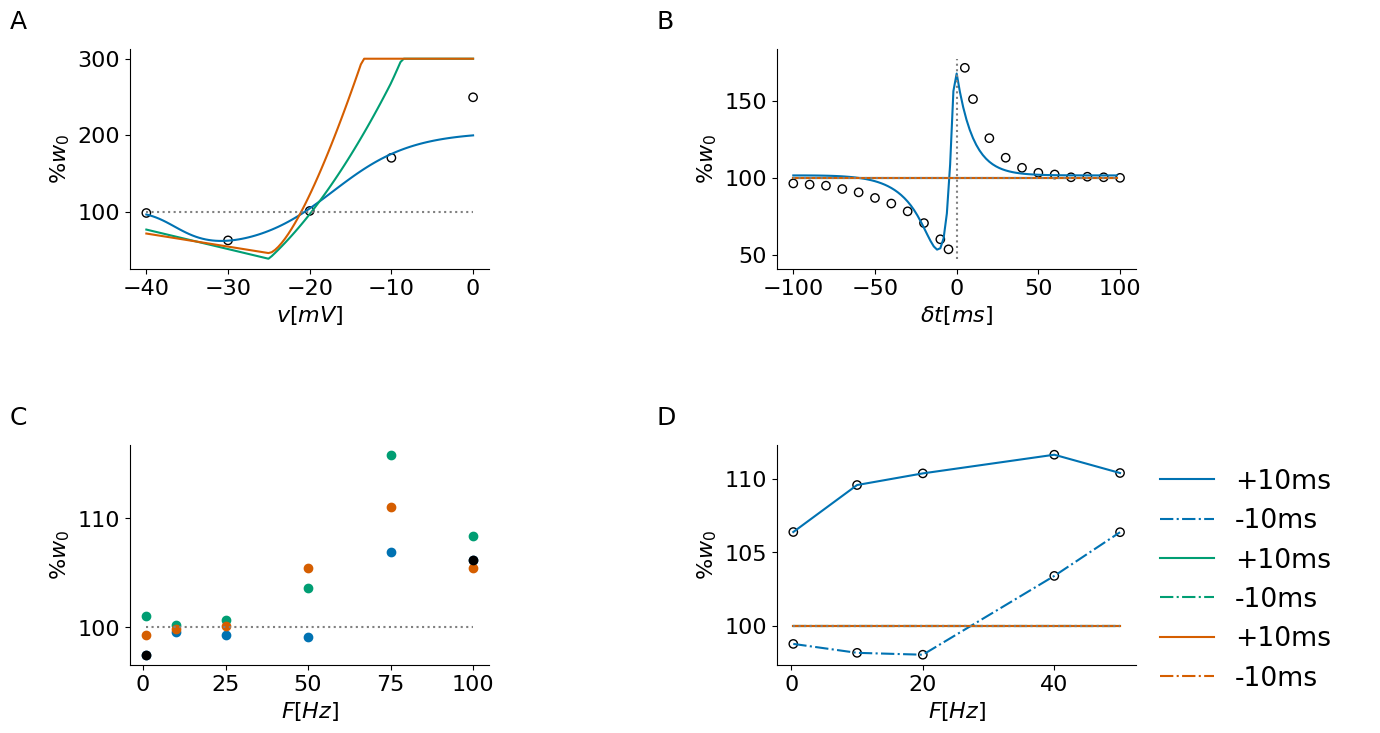

In [87]:
layout = '''
    AABB
    CCDD
    '''

fig = plt.figure(figsize=(16, 8))

height_ratios = [1,1]
width_ratios = [2,1, 2, 1]

specs, gs = panel_specs(layout, fig=fig)
gs.set_height_ratios(height_ratios)
gs.set_width_ratios(width_ratios)
gs.hspace=0.8
axes = {}
for letter in 'ABCD':
    axes[letter] =  ax = fig.add_subplot(specs[letter])
label_panels(axes, letters='ABCD', postfix='', offset_left=1.2)
for a in list('ABCD'):
    axes[a].set_axis_off()

palette = plt.rcParams['axes.prop_cycle'].by_key()['color']  

#plot v_dep
ax = fig.add_subplot(gs[0,0])
ax.scatter(vdat[:,0], vdat[:,1], label='Ngezahayo et al (2000)', color = 'k', facecolors='none')
ax.plot(v_values, vdep_simdata, color = palette[0])
ax.plot(v_values, vdep_simdata_cl, color = palette[1])
ax.plot(v_values, vdep_simdata_mb, color = palette[2])
ax.plot(vdat[:,0],vdat[:,0]*0+100, color = 'grey', linestyle = ':')
ax.ticklabel_format(useOffset=False, style = 'plain')
ax.set_xlabel('$v [mV]$')
ax.set_ylabel('$\% w_{0}$')
#ax.legend( bbox_to_anchor=(1.0, 1.0), loc='upper left',  frameon = False)
ax.ticklabel_format(useOffset=False, style = 'plain')
clear_axes(ax)


#plot kernels
ax = fig.add_subplot(gs[0,2])
ax.scatter(stdp_dat[:,0], stdp_dat[:,1], color = 'k', label = 'Froemke and Dan (2002)', facecolors='none')
ax.plot(stdp_dt, stdp_simdata, color = palette[0])
ax.plot(stdp_dt, stdp_simdata_cl, color = palette[1])
ax.plot(stdp_dt, stdp_simdata_mb, color = palette[2])
#set the cross
mins, maxs = ax.get_ylim()
minsx, maxsx = ax.get_xlim()
ax.plot([0,0],[mins, maxs], color = 'grey', linestyle = ':')
ax.plot(stdp_dt,stdp_dt * 0 + 100, color = 'grey', linestyle = ':')
ax.set_xlabel('$\delta t [ms]$') 
ax.set_ylabel('$\% w_{0}$')
ax.ticklabel_format(useOffset=False, style = 'plain')
#ax.legend( bbox_to_anchor=(1.0, 1.0), loc='upper left',  frameon = False)
ax.ticklabel_format(useOffset=False, style = 'plain')
clear_axes(ax)


#plot prefreq data 
ax = fig.add_subplot(gs[1,0])
ax.scatter(freqs, lfstbs_simdata , color = palette[0])
ax.scatter(freqs, lfstbs_simdata_cl, color = palette[1])
ax.scatter(freqs, lfstbs_simdata_mb, color = palette[2])
ax.plot(freqs, freqs*0+100, color = 'grey', linestyle = ':')
ax.scatter(freqs[[0,-1]], lfstbs_simdata[[0,-1]], color = 'k')
ax.set_xlabel('$F [Hz]$') 
ax.set_ylabel('$\% w_{0}$')
ax.ticklabel_format(useOffset=False, style = 'plain')
clear_axes(ax)

#plot freqdep data
ax = fig.add_subplot(gs[1,2])
#ax.plot( freqs_test[:2], target_freqdep[:,0], color = palette[0], label = 'Inglebert et al. ')
#ax.plot( freqs_test[:2], target_freqdep[:,1], linestyle = '-.', color = palette[0])

#ax.scatter( freqdep_sjostrom[:,0],freqdep_sjostrom[:,1], color = 'k', facecolors='none')
#ax.scatter( freqdep_sjostrom[:,0], freqdep_sjostrom[:,2], color = 'k', facecolors='none')

ax.plot(test_freqs, fredep_simdata[:,0], color = palette[0], label = '+10ms')
ax.plot(test_freqs, fredep_simdata[:,1], linestyle = '-.', color = palette[0], label = '-10ms')
ax.plot(test_freqs, fredep_simdata_cl[:,0], color = palette[1], label = '+10ms')
ax.plot(test_freqs, fredep_simdata_cl[:,1], linestyle = '-.', color = palette[1], label = '-10ms')
ax.plot(test_freqs, fredep_simdata_mb[:,0], color = palette[2], label = '+10ms')
ax.plot(test_freqs, fredep_simdata_mb[:,1], linestyle = '-.', color = palette[2], label = '-10ms')

ax.scatter(test_freqs, fredep_simdata[:,0], color = 'k', facecolors='none')
ax.scatter(test_freqs, fredep_simdata[:,1], color = 'k', facecolors='none')

minsx, maxsx = ax.get_xlim()
ax.plot(test_freqs,test_freqs*0+100, color = 'grey', linestyle = ':')
ax.set_ylabel('$\% w_{0}$')
ax.set_xlabel('$F [Hz]$')
ax.legend( bbox_to_anchor=(1.0, 1.0), loc='upper left',  frameon = False)
ax.ticklabel_format(useOffset=False, style = 'plain')
clear_axes(ax)


#plt.savefig(figures_path+'appendix_fig2_exp_results.pdf', bbox_inches='tight')
plt.show()
